# 决策树简介

# 熵
+ 表示随机变量的不确定性  
$H(p)=-\sum_{i=1}^{n} p_{i} \log p_{i}$
+ 熵越大，随机变量的不确定性越大！！

# 熵的计算
$H(p)=-\sum_{i=1}^{n} p_{i} \log p_{i}$  
$H(D)=-\sum_{k=1}^{k} \frac{\left|C_{k}\right|}{|D|} \log _{2} \frac{\left|C_{k}\right|}{|D|}$

# 条件熵
定义如下：
$H(Y \mid X)=\sum_{i=1}^{n} p_{i} H\left(Y \mid X=x_{i}\right)$  
其中 $p_{i}=P\left(X=x_{i}\right)$    

---
$H(D \mid A)=\sum_{i=1}^{n} \frac{\left|D_{i}\right|}{D \mid} H\left(D_{i}\right)$  
$=-\sum_{i=1}^{n} \frac{\left|D_{i}\right|}{D \mid} \sum_{k=1}^{K} \frac{\left|D_{ik}\right|}{D_{i} \mid} \log _{2} \frac{\left|D_{ik}\right|}{\left|D_{i}\right|}$

# 信息增益  
+ 定义  
信息增益（也叫互信息），定义如下：  
$g(D,A) = H(D)-H(D|A)$  其中D是训练数据集，A是某个特征
+ 根据信息增益准则的特征选择方法是：
    1. 对训练数据集（或子集）D， 计算其中每个特征的洗洗增益
    2. 比较他们的大小，选择信息增益最大的特征
+ 信息增益法
    1. 计算数据集D的经验熵$H(D)$:   
    $H(D)=-\sum_{k=1}^{k} \frac{\left|C_{k}\right|}{|D|} \log _{2} \frac{\left|C_{k}\right|}{|D|}$
    2. 计算特征A对数据集的经验条件熵$H(D|A)$  
    $H(D \mid A)=\sum_{i=1}^{n} \frac{\left|D_{i}\right|}{|D|} H\left(D_{i}\right)=-\sum_{i=1}^{n} \frac{\left|D_{i}\right|}{|D|} \sum_{k=1}^{k} \frac{\left|D_{ik}\right|}{\left|D_{i}\right|} \log _{2} \frac{\left|D_{ik}\right|}{\left|D_{i}\right|}$
    3. 计算信息增益   
    $g(D,A) = H(D)-H(D|A)$


+ 例子  
![](./img/4_1.png)

+ ID3算法： 在决策树递归构建过程中，使用信息增益的方法进行特征选择
+ 决策树生成过程：  
 1. 从根节点开始计算所有特征的信息增益，选择信息增益最大的特征作为结点特征
 2. 再对子节点递归以上的方法，构建决策树
 3. 所有特征信息增益很小或没有特征可以选择时递归结束得到一颗决策树

# ID3代码实现
![](./img/4_2.png)

In [1]:
def loaddata():
    feature_name = ['age','job','house','credit']
    dataSet = [[0, 0,0,0, 'no'],
               [0, 0,0,1,'no'],
               [0, 1,0,1, 'yes'],
               [0, 1,1,0, 'yes'],
               [0, 0,0,0, 'no'],
               [1, 0,0,0, 'no'],
               [1, 0,0,1, 'no'],
               [1, 1,1,1, 'yes'],
               [1, 0,1,2, 'yes'],
               [1, 0,1,2, 'yes'],
               [2, 0,1,2, 'yes'],
               [2, 0,1,1, 'yes'],
               [2, 1,0,1, 'yes'],
               [2, 1,0,2, 'yes'],
               [2, 0,0,0,'no']]
    
    return dataSet, feature_name
datas, features = loaddata()
datas[:3]

[[0, 0, 0, 0, 'no'], [0, 0, 0, 1, 'no'], [0, 1, 0, 1, 'yes']]

In [18]:
from scipy import math
def entropy(datas):
    entropy_ = 0
    label_counts = {}
    goaldata = [d[-1] for d in datas]
    length = len(datas)
    for d in goaldata:
        label_counts[d] = label_counts.get(d, 0) + 1
    
    for k, v in label_counts.items():
        p = v / length
        e_ = - p * math.log2(p)
        entropy_ += e_
    return entropy_

def feature_entropy(datas, axis):
    all_length = len(datas)
    feature_entropy = 0
    discounts = set([d[axis] for d in datas])
    for dis in discounts:
        data = [d for d in datas if d[axis] == dis]
        data_length = len(data)
        e = (data_length / all_length) * entropy(data)
        feature_entropy += e
    return feature_entropy

def choose_best_feature(datas, features):
    
    all_e = entropy(datas)
    info_gain = []
    for idx, feature in enumerate(features):
        feature_e = feature_entropy(datas, idx)
        diff = all_e - feature_e
        info_gain.append(diff)
    
    max_ = max(info_gain)
    idx = info_gain.index(max_)
    feature = features[idx]
#     print(datas, features, info_gain)
    return idx, feature
    

#划分数据集
def split_dataset(datas, axis, value):
    ret_dataset = [d[0:axis] + d[axis+1:] for d in datas if d[axis] == value]
    return ret_dataset

def class_vote(class_list):
    class_set = set(class_list)
    class_count = {c: class_list.count(c) for c in class_set}
    class_count = sorted(class_count.items(), key=lambda d: d[1], reverse=True)
    return class_count[0][0]

def train_tree(datas, features):
    classlist = [d[-1] for d in datas]
    if len(set(classlist)) == 1: #就剩下一个类别
        return classlist[0]
    if len(datas[0]) == 2: #就剩下一个特征
        return class_vote(classlist)
    bestidx, bestfeature = choose_best_feature(datas, features)
    my_tree = {bestfeature:{}}
    sub_features = [f for f in features if f != bestfeature]
    best_datas = [d[bestidx] for d in datas]
    for value in set(best_datas):
        sub_datas = split_dataset(datas, bestidx, value)
        my_tree[bestfeature][value] = train_tree(sub_datas, sub_features)
    return my_tree
        

In [20]:
datas, features = loaddata()
mytree = train_tree(datas, features)
print(mytree)

{'house': {0: {'job': {0: 'no', 1: 'yes'}}, 1: 'yes'}}


In [21]:
mytree.keys()

dict_keys(['house'])

In [43]:
def predict(mytree, features, testdata):
    firstkey = list(mytree.keys())[0]
    subtree = mytree.get(firstkey)
    idx = features.index(firstkey)
    dv = testdata[idx]
    subtree = subtree.get(dv)
    if isinstance(subtree, dict):
        classlabel = predict(subtree, features, testdata)
    else:
        classlabel = subtree
        
    return classlabel
        

In [44]:
predict(mytree, features, [1, 1, 0, 1])

'yes'

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

array(['yes'], dtype='<U3')

[Text(200.88000000000002, 181.2, 'house <= 0.5\ngini = 0.48\nsamples = 15\nvalue = [6, 9]'),
 Text(133.92000000000002, 108.72, 'job <= 0.5\ngini = 0.444\nsamples = 9\nvalue = [6, 3]'),
 Text(66.96000000000001, 36.23999999999998, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(200.88000000000002, 36.23999999999998, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(267.84000000000003, 108.72, 'gini = 0.0\nsamples = 6\nvalue = [0, 6]')]

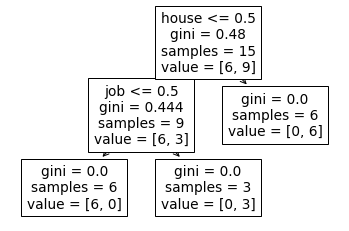

In [60]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
dtc = DecisionTreeClassifier()
X = np.array([d[:-1] for d in datas])
y = np.array([d[-1] for d in datas]).reshape(-1, 1)
dtc.fit(X, y)
dtc.predict([[1, 1, 0, 1]])
plot_tree(dtc, feature_names=features)

# C4.5算法

C4.5是对ID3的改进， 在树的生成过程中，使用信息增益比来选择特征  
ID3计算信息增益的公式：$g(D,A)=H(D)-H(D|A)$  
C4.5计算信息增益比公式：  
$g_{R}(D, A)=\frac{g(D, A)}{H_{A}(D)}$  
其中$H_{A}(D)=-\sum_{i=1}^{n} \frac{\left|D_{i}\right|}{|D|} \log _{2} \frac{\left|D_{i}\right|}{|D|}$

# Gini指数

CART算法：在树生成过程中，使用基尼指数选择最优特征。征程的是二叉树。  
1. 设样本点属于第K累的概率为$p_k$, 则$Gini(p)=\sum_{k=1}^{k}p_k(1-p_k)=1-\sum_{k=1}^{k}p_k^2$   
2. 给定样本集合D， 起基尼指数为： $\operatorname{Gini}(D)=1-\sum_{k=1}^{K}\left(\frac{|C_{k} \mid}{|D|}\right)^{2}$  
3. 在特定A的条件下，集合D的基尼指数为：$\operatorname{Gini}(D, A)=\frac{\left|D_{1}\right|}{|D|} \operatorname{Gini}(D 1)+\frac{\left|D_{2}\right|}{|D|} \operatorname{Gini}(D 2)$  
基尼指数越大，样本你的不确定性越大，这点与熵相似。

# 决策树剪枝
+ 预剪枝（根据验证集精度是否提升，不提高去停止）
+ 后剪枝（先生成整个树，然后找到最深的叶子节点，如果去掉，精度提升，则剪掉），训练开销大，泛化性能好

# 决策树处理连续值和离散值
+ 连续值， 采用二分法
+ 缺失值， 不包含缺失值计算信息增益，然后计算非缺失值比例。然后缺失值的数据按照权重进入所有的分支里。

# 多变量决策树
分裂的时候使用线性分类器

# sklearn

In [6]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

Sklearn中实现的决策树都是二叉树

DecisionTreeClassifier的常用参数含义：
- criterion：‘gini’ or ‘entropy’ (default=”gini”)，前者是基尼系数，后者是信息熵。
- max_depth：决策树最大深度。常用来解决过拟合。
- min_impurity_decrease：这个值限制了决策树的增长，如果某节点的不纯度(基尼系数，信息增益)小于这个阈值，则该节点不再生成子节点。
- min_samples_split：如果是 int，则取传入值本身作为最小样本数； 如果是 float，则用 ceil(min_samples_split * 样本数量) 的值作为最小样本数，即向上取整。
- min_samples_leaf：如果是 int，则取传入值本身作为最小样本数； 如果是 float，则去 ceil(min_samples_leaf * 样本数量) 的值作为最小样本数，即向上取整。 这个值限制了叶子节点最少的样本数，如果某叶子节点数目小于样本数，则会和兄弟节点一起被剪枝。
- max_leaf_nodes：最大叶子节点数。如果特征不多，可以不考虑这个值，但是如果特征分成多的话，可以加以限制，具体的值可以通过交叉验证得到。
- min_impurity_split：决策树在创建分支时，信息增益（基尼系数）必须大于这个阀值，否则不分裂

In [7]:
def loaddata():
    dataSet = [[0, 0,0,0, 'no'],
               [0, 0,0,1,'no'],
               [0, 1,0,1, 'yes'],
               [0, 1,1,0, 'yes'],
               [0, 0,0,0, 'no'],
               [1, 0,0,0, 'no'],
               [1, 0,0,1, 'no'],
               [1, 1,1,1, 'yes'],
               [1, 0,1,2, 'yes'],
               [1, 0,1,2, 'yes'],
               [2, 0,1,2, 'yes'],
               [2, 0,1,1, 'yes'],
               [2, 1,0,1, 'yes'],
               [2, 1,0,2, 'yes'],
               [2, 0,0,0,'no']]
    feature_name = ['age','job','house','credit']
    return dataSet, feature_name

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

array(['yes'], dtype='<U11')

[Text(200.88000000000002, 181.2, 'house <= 0.5\ngini = 0.48\nsamples = 15\nvalue = [6, 9]'),
 Text(133.92000000000002, 108.72, 'job <= 0.5\ngini = 0.444\nsamples = 9\nvalue = [6, 3]'),
 Text(66.96000000000001, 36.23999999999998, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(200.88000000000002, 36.23999999999998, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(267.84000000000003, 108.72, 'gini = 0.0\nsamples = 6\nvalue = [0, 6]')]

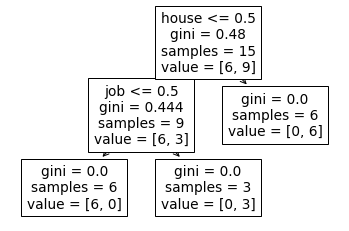

In [9]:
myDat,feature_name = loaddata()
X = np.array(myDat)[:,0:4]
y = np.array(myDat)[:,-1]
model = DecisionTreeClassifier()
model.fit(X,y)
model.predict([[1,1,0,1]])
plot_tree(model, feature_names=feature_name)

# 使用决策树进行个人信用风险评估
[1 数据源](#1)<br>
[2 数据探索和预处理](#2)<br>
[3 划分训练集和测试集](#3)<br>
[4 模型训练](#4)<br>
[5 模型性能评估](#5)<br>
[6 模型性能提升](#6)<br>

## 数据源
使用UCI上的德国信用数据集。该数据集包含了1000个贷款信息，每一个贷款有20个自变量和一个类变量记录该笔贷款是否违约。
我们将使用该数据集构建模型来预测贷款是否违约。

## 数据探索和预处理

In [19]:
credit = pd.read_csv("./data/4_1.csv")
credit.head(2)

,default,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,personal_status_sex,...,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
0,0,< 0 DM,6,critical account/ other credits existing (not ...,domestic appliances,1169,unknown/ no savings account,.. >= 7 years,4,male : single,...,4,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes
1,1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,...,2,real estate,22,none,own,1,skilled employee / official,1,none,yes


In [20]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   default                     1000 non-null   int64 
 1   account_check_status        1000 non-null   object
 2   duration_in_month           1000 non-null   int64 
 3   credit_history              1000 non-null   object
 4   purpose                     1000 non-null   object
 5   credit_amount               1000 non-null   int64 
 6   savings                     1000 non-null   object
 7   present_emp_since           1000 non-null   object
 8   installment_as_income_perc  1000 non-null   int64 
 9   personal_status_sex         1000 non-null   object
 10  other_debtors               1000 non-null   object
 11  present_res_since           1000 non-null   int64 
 12  property                    1000 non-null   object
 13  age                         1000 non-null   int64

In [21]:
#取字符串的数组
cols = ['account_check_status','credit_history', 'purpose', 'savings', 'present_emp_since','personal_status_sex', 
        'other_debtors','property','other_installment_plans','housing','job','telephone','foreign_worker']
#映射字典
col_dicts = {}
col_dicts = {
  'account_check_status': {
    '0 <= ... < 200 DM': 2,
    '< 0 DM': 1,
    '>= 200 DM / salary assignments for at least 1 year': 3,
    'no checking account': 0
  },
             
  'credit_history': {
      'existing credits paid back duly till now': 0,
      'critical account/ other credits existing (not at this bank)': 1,
      'delay in paying off in the past': 2,
      'all credits at this bank paid back duly': 3,
      'no credits taken/ all credits paid back duly': 4
  },
           
  'purpose': {
      'domestic appliances': 0,
      'car (new)': 1,
      'radio/television': 2,
      'car (used)': 3,
      'business': 4,
      '(vacation - does not exist?)': 5,
      'education': 6,
      'furniture/equipment': 7,
      'repairs': 8,
      'retraining': 9
  },
                
 'savings': {'... < 100 DM': 0,
  'unknown/ no savings account': 1,
  '100 <= ... < 500 DM': 2,
  '500 <= ... < 1000 DM': 3,
  '.. >= 1000 DM': 4},
  
 'present_emp_since':{
     '1 <= ... < 4 years':0,
     '.. >= 7 years':1,
     '4 <= ... < 7 years':2,
     '... < 1 year':3,
     'unemployed':4
 },
 
'other_installment_plans':{
    'none':0,
    'bank':1,
    'stores':2
},
             
 'foreign_worker': {'no': 1, 'yes': 0},
             
 'housing': {'for free': 1, 'own': 0, 'rent': 2},
                               
 'job': {'skilled employee / official': 0,
  'unskilled - resident': 1,
  'management/ self-employed/ highly qualified employee/ officer': 2,
  'unemployed/ unskilled - non-resident': 3},
             
 'other_debtors': {'co-applicant': 2, 'guarantor': 1, 'none': 0},
             
 'personal_status_sex': {'male : single': 0,
  'female : divorced/separated/married': 1,
  'male : married/widowed': 2,
  'male : divorced/separated': 3},
           
 'property': {'if not A121/A122 : car or other, not in attribute 6': 0,
  'real estate': 1,
  'if not A121 : building society savings agreement/ life insurance': 2,
  'unknown / no property': 3},
             
 'telephone': {'none': 0, 'yes, registered under the customers name': 1}}

for col in cols:
    credit[col] = credit[col].map(lambda x: x.strip())
    credit[col] = credit[col].map(col_dicts[col])
    
credit.head(5)

,default,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,personal_status_sex,...,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
0,0,1,6,1,0,1169,1,1,4,0,...,4,1,67,0,0,2,0,1,1,0
1,1,2,48,0,0,5951,0,0,2,1,...,2,1,22,0,0,1,0,1,0,0
2,0,0,12,1,5,2096,0,2,2,0,...,3,1,49,0,0,1,1,2,0,0
3,0,1,42,0,2,7882,0,2,2,0,...,4,2,45,0,1,1,0,2,0,0
4,1,1,24,2,1,4870,0,0,3,0,...,4,3,53,0,1,2,0,2,0,0


## 划分数据集

In [22]:
from sklearn.model_selection import train_test_split
y = credit['default']
X  = credit.loc[:,'account_check_status':'foreign_worker']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [23]:
print (y_train.value_counts()/len(y_train))
print (y_test.value_counts()/len(y_test))

0    0.694286
1    0.305714
Name: default, dtype: float64
0    0.713333
1    0.286667
Name: default, dtype: float64


# 模型训练

In [24]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

[Text(159.09154411764706, 208.38, 'X[0] <= 0.5\ngini = 0.425\nsamples = 700\nvalue = [486, 214]'),
 Text(81.85367647058824, 190.26, 'X[13] <= 0.5\ngini = 0.221\nsamples = 276\nvalue = [241, 35]'),
 Text(60.31323529411765, 172.14, 'X[9] <= 0.5\ngini = 0.167\nsamples = 229\nvalue = [208, 21]'),
 Text(46.773529411764706, 154.01999999999998, 'X[4] <= 4367.5\ngini = 0.144\nsamples = 217\nvalue = [200, 17]'),
 Text(34.464705882352945, 135.89999999999998, 'X[3] <= 5.5\ngini = 0.088\nsamples = 174\nvalue = [166, 8]'),
 Text(29.541176470588237, 117.77999999999999, 'X[11] <= 0.5\ngini = 0.07\nsamples = 166\nvalue = [160, 6]'),
 Text(19.694117647058825, 99.66, 'X[4] <= 3230.5\ngini = 0.165\nsamples = 55\nvalue = [50, 5]'),
 Text(14.770588235294118, 81.53999999999999, 'X[2] <= 1.5\ngini = 0.115\nsamples = 49\nvalue = [46, 3]'),
 Text(9.847058823529412, 63.41999999999999, 'X[4] <= 1192.5\ngini = 0.046\nsamples = 42\nvalue = [41, 1]'),
 Text(4.923529411764706, 45.29999999999998, 'gini = 0.245\nsampl

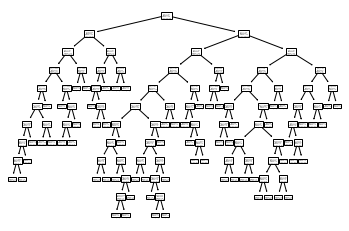

In [25]:
dtc = DecisionTreeClassifier(min_samples_leaf = 6,random_state=1)
dtc.fit(X_train, y_train)
plot_tree(dtc)

## 模型性能评估

![](./img/4_3.png)

In [26]:
y_pre = dtc.predict(X_test)

In [27]:
from sklearn.metrics import confusion_matrix, classification_report 
confusion_matrix(y_test, y_pre)
print(classification_report(y_test, y_pre))

array([[177,  37],
       [ 52,  34]], dtype=int64)

              precision    recall  f1-score   support

           0       0.77      0.83      0.80       214
           1       0.48      0.40      0.43        86

    accuracy                           0.70       300
   macro avg       0.63      0.61      0.62       300
weighted avg       0.69      0.70      0.69       300



## 模型性能提升
在实际应用中，模型的预测正确率不高，很难将其应用到实时的信贷评审过程。
在本案例中，如果一个模型将所有的贷款都预测为“未违约”，此时模型的正确率将为72%，而该模型是一个完全无用的模型。
上节中我们建立的模型，正确率为70%，但是对于违约贷款的识别性能很差。
我们可以通过创建一个代价矩阵定义模型犯不同错误时的代价。
假设我们认为一个贷款违约者给银行带来的损失是银行错过一个不违约的贷款带来损失的4倍，则未违约和违约的代价权重可以定义为：

In [29]:
class_weights = {0:1, 1:4}
credit_model_cost = DecisionTreeClassifier(max_depth=6,class_weight = class_weights)
credit_model_cost.fit(X_train, y_train)
credit_pred_cost = credit_model_cost.predict(X_test)

print (classification_report(y_test, credit_pred_cost))
print (confusion_matrix(y_test, credit_pred_cost))


DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 1, 1: 4},
                       criterion='gini', max_depth=6, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

              precision    recall  f1-score   support

           0       0.91      0.54      0.68       214
           1       0.43      0.86      0.57        86

    accuracy                           0.63       300
   macro avg       0.67      0.70      0.63       300
weighted avg       0.77      0.63      0.65       300

[[116  98]
 [ 12  74]]


可见，模型的整体正确率下降为63%，但是此时的模型能将86个违约贷款中的74个正确识别，识别率为85%(recall值)。